1️⃣ 国家×月份的 ppp_parity_vs_us 箱线图/时序中位数


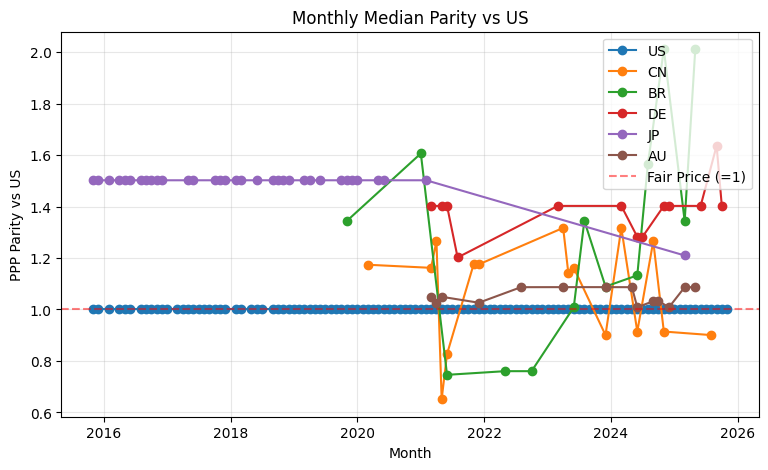

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

df = pd.read_csv('data1.csv')
df['event_date'] = pd.to_datetime(df['event_date'])
df['month'] = df['event_date'].dt.to_period('M').dt.to_timestamp()

# 过滤有效数据（排除免费游戏和异常值）
valid = df[(df['ppp_parity_vs_us'] > 0) &
           (df['ppp_parity_vs_us'] < 4) &
           (df['price_ppp_intd'] > 0)].copy()

# 按国家×月份分组，计算中位数
monthly_parity = valid.groupby(['country', 'month'])['ppp_parity_vs_us'].median().reset_index()

# 时序图（选几个主要国家）
top_countries = ['US', 'CN', 'BR', 'DE', 'JP', 'AU']
for country in top_countries:
    country_data = monthly_parity[monthly_parity['country'] == country]
    plt.plot(country_data['month'], country_data['ppp_parity_vs_us'],
             marker='o', label=country)

plt.axhline(1.0, linestyle='--', color='red', alpha=0.5, label='Fair Price (=1)')
plt.title('Monthly Median Parity vs US')
plt.xlabel('Month')
plt.ylabel('PPP Parity vs US')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

2️⃣ 节假日/周末 vs 非节假日/工作日的组间差异检验

Holiday vs Non-Holiday t-test: p=0.0146
Mann-Whitney U test: p=0.0026


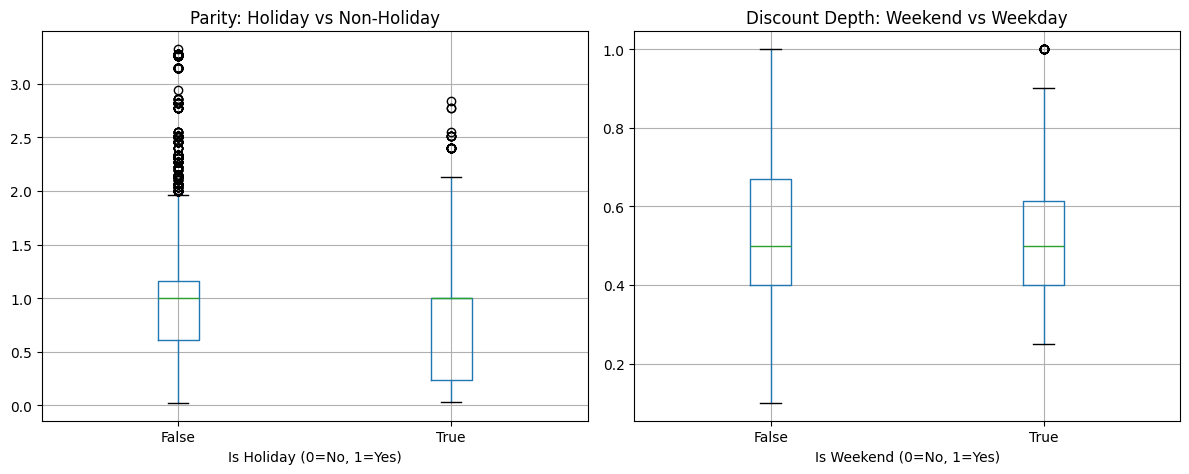

In [36]:
from scipy.stats import ttest_ind, mannwhitneyu

# 派生 is_weekend
df['is_weekend'] = df['event_date'].dt.dayofweek >= 5

# 1. 节假日 vs 非节假日
holiday = df[df['is_holiday_local'] == 1]['ppp_parity_vs_us'].dropna()
non_holiday = df[df['is_holiday_local'] == 0]['ppp_parity_vs_us'].dropna()

# t检验（假设正态分布）
t_stat, p_value = ttest_ind(holiday, non_holiday)
print(f"Holiday vs Non-Holiday t-test: p={p_value:.4f}")

# Mann-Whitney U（非参数，更稳健）
u_stat, p_value_mw = mannwhitneyu(holiday, non_holiday, alternative='two-sided')
print(f"Mann-Whitney U test: p={p_value_mw:.4f}")

# 2. 箱线图对比
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df.boxplot(column='ppp_parity_vs_us', by='is_holiday_local', ax=plt.gca())
plt.suptitle('')
plt.title('Parity: Holiday vs Non-Holiday')
plt.xlabel('Is Holiday (0=No, 1=Yes)')

plt.subplot(1, 2, 2)
df.boxplot(column='ppp_price_over_regular_intd', by='is_weekend', ax=plt.gca())
plt.suptitle('')
plt.title('Discount Depth: Weekend vs Weekday')
plt.xlabel('Is Weekend (0=No, 1=Yes)')

plt.tight_layout()
plt.show()

3️⃣ ppp_price_over_regular_intd 的国别分位数（q10/q25/中位/q75/q90）

          q10    q25  median    q75   q90
country                                  
AR       0.25  0.400    0.50  0.670  0.80
AU       0.25  0.400    0.50  0.670  0.80
BR       0.25  0.400    0.50  0.699  0.80
CA       0.25  0.400    0.50  0.670  0.80
CN       0.25  0.393    0.50  0.695  0.85
DE       0.25  0.400    0.50  0.670  0.80
FR       0.25  0.400    0.50  0.670  0.80
GB       0.25  0.400    0.50  0.670  0.80
JP       0.25  0.400    0.55  0.750  0.80
PL       0.25  0.400    0.50  0.670  0.80
TR       0.25  0.400    0.50  0.700  0.90
US       0.25  0.400    0.50  0.670  0.80


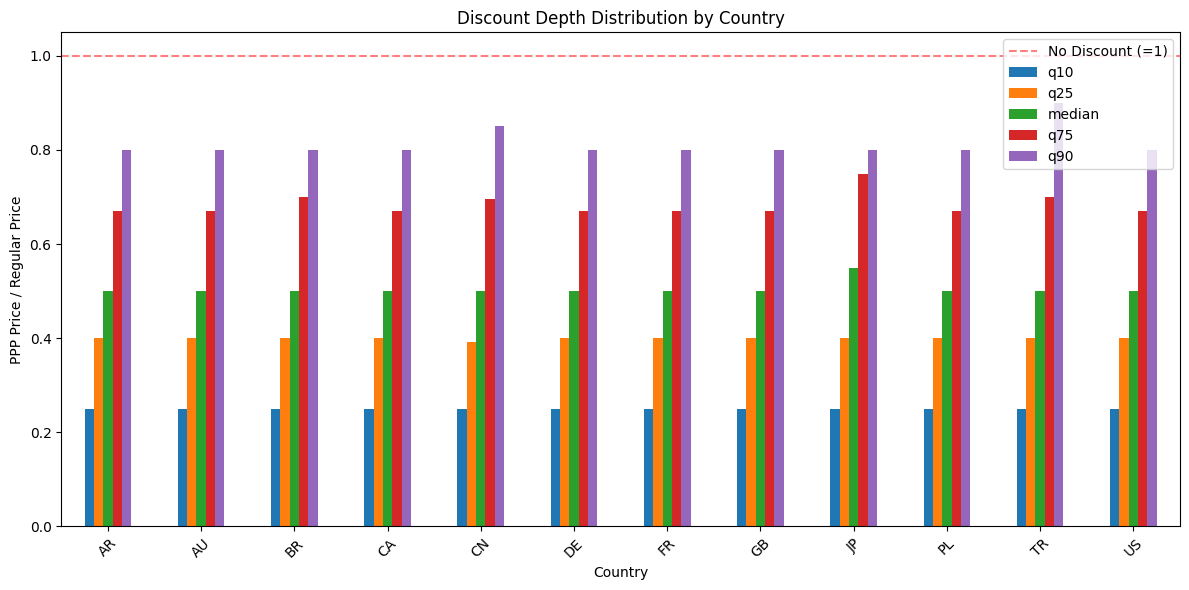

In [19]:
# 计算每个国家的分位数
quantiles = df.groupby('country')['ppp_price_over_regular_intd'].quantile([0.1, 0.25, 0.5, 0.75, 0.9]).unstack()
quantiles.columns = ['q10', 'q25', 'median', 'q75', 'q90']

print(quantiles.round(3))

# 可视化
quantiles.plot(kind='bar', figsize=(12, 6))
plt.axhline(1.0, linestyle='--', color='red', alpha=0.5, label='No Discount (=1)')
plt.title('Discount Depth Distribution by Country')
plt.xlabel('Country')
plt.ylabel('PPP Price / Regular Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

4️⃣ 研究"持续时间"：Join starts_only_duration.csv

✓ Loaded 9385 rows
Columns: ['appid', 'gid', 'country', 'timestamp', 'price', 'regular', 'cut', 'currency', 'shop_id', 'release_time', 'release_price', 'release_currency', 'release_country', 'is_sale', 'is_currency_change', 'is_currency_change_at_start', 'is_base_change', 'is_release_day', 'is_release_day_sale', 'is_release_day_base_change', 'days_since_release', 'delta_from_release_price', 'delta_pct_from_release', 'ts_day', 'note_day0_fx_needed', 'note_day0_fx_rebased', 'sale_ep_duration_days', 'sale_ep_is_start', 'local_date', 'is_holiday_local', 'holiday_names_local', 'price_ppp_intd', 'regular_ppp_intd', 'ppp_price_over_regular_intd', 'holiday_window_pre_days', 'holiday_window_post_days', 'LCU', 'event_date', 'fx_to_lcu', 'price_lcu_for_ppp', 'regular_lcu_for_ppp', 'ppp_lcu_per_int_dollar', 'price_ppp_intd_US', 'ppp_parity_vs_us']

✓ 'sale_ep_duration_days' found in data1.csv!
✓ Valid samples: 9005

Spearman r = -0.028, p = 0.0079


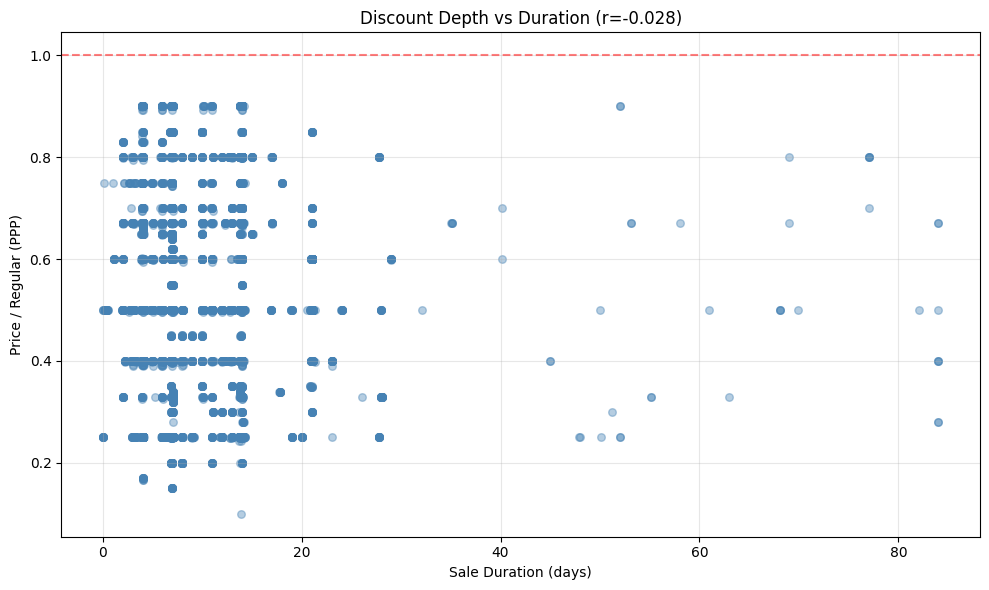


By duration:
                  mean  count
duration_bin                 
1-7d          0.533532   3336
8-14d         0.517129   4079
15-30d        0.512891   1545
31-90d        0.535538     45
90d+               NaN      0


/tmp/ipython-input-2201726740.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(valid.groupby('duration_bin')['ppp_price_over_regular_intd'].agg(['mean', 'count']))


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# 直接读 data1.csv
df = pd.read_csv('data1.csv')
df.columns = df.columns.str.strip()

print(f"✓ Loaded {df.shape[0]} rows")
print(f"Columns: {df.columns.tolist()}")

# 检查是否有 duration 列
if 'sale_ep_duration_days' in df.columns:
    print("\n✓ 'sale_ep_duration_days' found in data1.csv!")

    # 过滤有效数据
    valid = df[
        (df['sale_ep_duration_days'] > 0) &
        (df['ppp_price_over_regular_intd'].notna()) &
        (df['ppp_price_over_regular_intd'].between(0.1, 1.5))
    ].copy()

    print(f"✓ Valid samples: {len(valid)}")

    # 相关性
    corr, p = spearmanr(valid['sale_ep_duration_days'],
                         valid['ppp_price_over_regular_intd'])
    print(f"\nSpearman r = {corr:.3f}, p = {p:.4f}")

    # 散点图
    plt.figure(figsize=(10, 6))
    plt.scatter(valid['sale_ep_duration_days'],
                valid['ppp_price_over_regular_intd'],
                alpha=0.4, s=30, color='steelblue')
    plt.axhline(1.0, linestyle='--', color='red', alpha=0.5)
    plt.xlabel('Sale Duration (days)')
    plt.ylabel('Price / Regular (PPP)')
    plt.title(f'Discount Depth vs Duration (r={corr:.3f})')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 分桶
    valid['duration_bin'] = pd.cut(
        valid['sale_ep_duration_days'],
        bins=[0, 7, 14, 30, 90, 999],
        labels=['1-7d', '8-14d', '15-30d', '31-90d', '90d+']
    )

    print("\nBy duration:")
    print(valid.groupby('duration_bin')['ppp_price_over_regular_intd'].agg(['mean', 'count']))

else:
    print("❌ Column not found!")

5️⃣ 质量审计：MAD/IQR 标记极值

In [22]:
import numpy as np

# 1. MAD 检测
def detect_outliers_mad(data, threshold=3.5):
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    modified_z_scores = 0.6745 * (data - median) / mad
    return np.abs(modified_z_scores) > threshold

# 应用到 ppp_parity_vs_us
df['is_outlier_mad'] = detect_outliers_mad(df['ppp_parity_vs_us'].dropna())

# 2. IQR 检测
Q1 = df['ppp_parity_vs_us'].quantile(0.25)
Q3 = df['ppp_parity_vs_us'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['is_outlier_iqr'] = (df['ppp_parity_vs_us'] < lower_bound) | (df['ppp_parity_vs_us'] > upper_bound)

# 3. 检查异常值
print(f"MAD outliers: {df['is_outlier_mad'].sum()}")
print(f"IQR outliers: {df['is_outlier_iqr'].sum()}")

# 4. 抽样核查
outliers = df[df['is_outlier_iqr']]
print(outliers[['appid', 'country', 'currency', 'price', 'regular', 'ppp_parity_vs_us']].head(10))

MAD outliers: 448
IQR outliers: 324
      appid country currency  price  regular  ppp_parity_vs_us
0   1030300      AR      USD  19.99    19.99          3.151213
2   1086940      AR      USD  53.99    59.99          2.001303
3   1086940      AR      USD  50.99    59.99          2.063570
4   1086940      AR      USD  47.99    59.99          2.128185
5   1086940      AR      USD  47.99    59.99          2.266255
6   1086940      AR      USD  47.99    59.99          2.332693
7   1086940      AR      USD  47.99    59.99          2.332693
8   1086940      AR      USD  47.99    59.99          2.404325
9   1086940      AR      USD  47.99    59.99          2.504307
10  1086940      AR      USD  47.99    59.99          2.516031
